### Preparation DataFrame to be used for analysis high-frequency tidal gauge data (RWS) and comparison with monthly metric averages (PSMSL website).

This online notebook retrieves data from the webservice of RWS and transforms the data in such format it can be used for further analysis. Furthermore the notebook shows how data from the RWS water webservices can be retrieved and is written to a single HDFStore.

In [1]:
import requests
import json

import numpy as np
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz

from multiprocessing.pool import ThreadPool
from tqdm import tqdm_notebook as tqdm
from time import time as timer
from IPython.display import clear_output

%matplotlib inline

The distribution layer of the webservice from Rijkswaterstaat is minimally documented at <a href="https://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf">DistributielaagWebservices-SUM-2v7.pdf</a>. 

There are four different services with different type of request within each service. The services are:
- MetadataServices 
- OnlinewaarnemingenServices (online measurement services)
- BulkwaarnemingServices (bulk measurement services)
- WebFeatureServices 

In this notebook the first two services are used to request the tide levels of the different gauge stations

In [2]:
collect_catalogus = ('https://waterwebservices.rijkswaterstaat.nl/' +
                     'METADATASERVICES_DBO/' +
                     'OphalenCatalogus/')
collect_observations = ('https://waterwebservices.rijkswaterstaat.nl/' +
                        'ONLINEWAARNEMINGENSERVICES_DBO/' +
                        'OphalenWaarnemingen')
collect_latest_observations = ('https://waterwebservices.rijkswaterstaat.nl/' +
                               'ONLINEWAARNEMINGENSERVICES_DBO/' +
                               'OphalenLaatsteWaarnemingen')

Start with a metadata request using the `OpenhalenCatalogus` service. In this request we want information on the units (eenheden), quantities (grootheden) and qualities (hoedanigheden).

In [3]:
# get station information from DDL (metadata uit Catalogus)
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(collect_catalogus, json=request)
result = resp.json()
# print all variables in the catalogus
# print(result)

df_locations = pd.DataFrame(result['LocatieLijst']).set_index('Code')
# load normalized JSON object (since it contains nested JSON)
df_metadata = pd.io.json.json_normalize(
    result['AquoMetadataLijst']).set_index('AquoMetadata_MessageID')

In [4]:
# note that there are two stations for IJmuiden.
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD',
       'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']
df_locations.loc[ids]

,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y
Code,,,,,
DELFZL,25831,84020,Delfzijl,761899.770960,5.915790e+06
DENHDR,25831,84011,Den Helder,617198.393684,5.869731e+06
HARLGN,25831,84096,Harlingen,661021.585505,5.894519e+06
HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06
IJMDBTHVN,25831,84132,IJmuiden buitenhaven,605633.035699,5.813598e+06
IJMDNDSS,25831,84560,IJmuiden Noordersluis,609033.673551,5.814221e+06
VLISSGN,25831,84387,Vlissingen,541425.983215,5.699182e+06


Continue with requesting the observations using the `OpenhalenWaarnemingen` (collect_observations) service

The waterwebservice make use of a POST query service based on JSON objects with the following 3 elemens defined:
- Locatie
- AquoPlusWaarnemingMetadata
- Periode

An example looks as follow:

In [5]:
request_manual = {
  'Locatie': {
    'X': 761899.770959577,
    'Y': 5915790.48491405,
    'Code': 'DELFZL'
  },
  'AquoPlusWaarnemingMetadata': {
    'AquoMetadata': {
      'Eenheid': {
        'Code': 'cm'
      },
      'Grootheid': {
        'Code': 'WATHTE'
      },
      'Hoedanigheid': {
        'Code': 'NAP'
      }
    }
  },
  'Periode': {
    'Einddatumtijd': '2012-01-27T09:30:00.000+01:00',
    'Begindatumtijd': '2012-01-27T09:00:00.000+01:00'
  }
}

This manual request can be send to the service. If successfull the service will return a JSON object that can be loaded into a pandas DataFrame and plotted in a figure

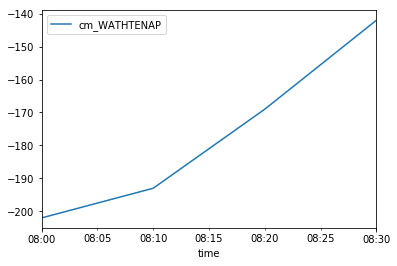

In [6]:
aqpwm = request_manual['AquoPlusWaarnemingMetadata']
unit = aqpwm['AquoMetadata']['Eenheid']['Code']
quantity = aqpwm['AquoMetadata']['Grootheid']['Code']
qualitiy = aqpwm['AquoMetadata']['Hoedanigheid']['Code']
column = unit+'_'+quantity+qualitiy

try:
    resp = requests.post(collect_observations, json=request_manual)
    df_out = pd.io.json.json_normalize(
        resp.json()['WaarnemingenLijst'][0]['MetingenLijst'])
    df_out = df_out[['Meetwaarde.Waarde_Numeriek', 'Tijdstip']]
    df_out['Tijdstip'] = pd.to_datetime(df_out['Tijdstip'])
    df_out.set_index('Tijdstip', inplace=True)
    df_out.index.name = 'time'
    df_out.columns = [column]
    df_out.loc[df_out[column] == 999999999.0] = np.nan
    df_out.plot()
except Exception as e:
    print(e)

Next we dynamically create the POST request

In [7]:
def strftime(date):
    """
    required datetime format is not ISO standard date format.
    current conversion method works, but improvements are welcome
    asked on SO, but no responses: https://stackoverflow.com/q/45610753/2459096
    """
    (dt, micro, tz) = date.strftime(
        '%Y-%m-%dT%H:%M:%S.%f%Z:00').replace('+', '.').split('.')
    dt = "%s.%03d+%s" % (dt, int(micro) / 1000, tz)
    return dt


def POST_collect_measurements(start_datetime, df_location, df_aquo_metadata):
    """
    create a JSOB object for a POST request for collection of observations

    Parameters
    ---
    start_datetime : datetime object inc tzinfo
        (end_datetime is hardcoded 1 month after start_datetime)
    df_location : dataframe
        with sinlge station location info
    df_aquo_metadata : dataframe
        with single unit/quantity/quality information

    Return
    ------
    JSON object
    """
    # empty json object
    request_dynamic = {}

    request_dynamic['Locatie'] = {}
    rd_location = request_dynamic['Locatie']
    rd_location['X'] = df_location.X
    rd_location['Y'] = df_location.Y
    rd_location['Code'] = df_location.name

    request_dynamic['AquoPlusWaarnemingMetadata'] = {}
    rd_apwm = request_dynamic['AquoPlusWaarnemingMetadata']
    rd_apwm['AquoMetadata'] = {}
    rd_aquo_metadata = rd_apwm['AquoMetadata']
    rd_aquo_metadata['Eenheid'] = {
        'Code': df_aquo_metadata['Eenheid.Code'].values[0]}
    rd_aquo_metadata['Grootheid'] = {
        'Code': df_aquo_metadata['Grootheid.Code'].values[0]}
    rd_aquo_metadata['Hoedanigheid'] = {
        'Code': df_aquo_metadata['Hoedanigheid.Code'].values[0]}

    request_dynamic['Periode'] = {}
    rd_period = request_dynamic['Periode']
    rd_period['Begindatumtijd'] = strftime(start_datetime)
    rd_period['Einddatumtijd'] = strftime(start_datetime +
                                          relativedelta(months=1))

    return request_dynamic

In [8]:
# create a long list of data objects
# only use start-dates since end-date is always 1 month after the start-date
start_dates = []
for year in np.arange(1890, 2018):
    for month in np.arange(1, 13):
        start_dates.append(datetime(year=year,
                                    month=month,
                                    day=1,
                                    hour=0,
                                    minute=0,
                                    tzinfo=pytz.timezone('Etc/GMT-1')))
start_dates = pd.Series(start_dates)
# startDates.head()

In [9]:
sel_dates = start_dates[(start_dates > '1890-01-01') &
                        (start_dates < '1890-06-01')]
sel_dates

1   1890-02-01 00:00:00+01:00
2   1890-03-01 00:00:00+01:00
3   1890-04-01 00:00:00+01:00
4   1890-05-01 00:00:00+01:00
5   1890-06-01 00:00:00+01:00
dtype: datetime64[ns, Etc/GMT-1]

In [10]:
# select a single station
for station in ids[0:1]:
    df_location = df_locations.loc[station]
df_location.head()

Coordinatenstelsel          25831
Locatie_MessageID           84020
Naam                     Delfzijl
X                          761900
Y                     5.91579e+06
Name: DELFZL, dtype: object

In [11]:
# select a metadata object using the unit/quanity/quality
df_WATHTE_NAP = df_metadata[(df_metadata['Grootheid.Code'] == 'WATHTE') &
                            (df_metadata['Hoedanigheid.Code'] == 'NAP')]
df_WATHTE_NAP.T.head()

AquoMetadata_MessageID,71
Eenheid.Code,cm
Eenheid.Omschrijving,centimeter
Grootheid.Code,WATHTE
Grootheid.Omschrijving,Waterhoogte
Hoedanigheid.Code,NAP


In [12]:
request_dynamic = POST_collect_measurements(start_datetime=sel_dates[3],
                                            df_location=df_location,
                                            df_aquo_metadata=df_WATHTE_NAP)
request_dynamic

{'AquoPlusWaarnemingMetadata': {'AquoMetadata': {'Eenheid': {'Code': 'cm'},
   'Grootheid': {'Code': 'WATHTE'},
   'Hoedanigheid': {'Code': 'NAP'}}},
 'Locatie': {'Code': 'DELFZL',
  'X': 761899.77095957706,
  'Y': 5915790.4849140504},
 'Periode': {'Begindatumtijd': '1890-05-01T00:00:00.000+01:00',
  'Einddatumtijd': '1890-06-01T00:00:00.000+01:00'}}

Open a HDFStore to retrieve month by month all observations and write to PyTables object.  

Create a function to fetch the data and write directly to disk.

In [13]:
def fetch_collect_obersvations(start_date, column_name):
    try:
        # prepare the POST object
        request_dynamic = POST_collect_measurements(
            start_datetime=start_date,
            df_location=df_location,
            df_aquo_metadata=df_WATHTE_NAP)
        # do the query
        resp = requests.post(collect_observations, json=request_dynamic)

        # parse the result to DataFrame
        df_out = pd.io.json.json_normalize(
            resp.json()['WaarnemingenLijst'][0]['MetingenLijst'])
        df_out = df_out[['Meetwaarde.Waarde_Numeriek', 'Tijdstip']]
        df_out['Tijdstip'] = pd.to_datetime(df_out['Tijdstip'])
        df_out.set_index('Tijdstip', inplace=True)
        df_out.columns = [column_name]
        df_out.index.name = 'time'
        df_out.loc[df_out[column_name] == 999999999.0] = np.nan
        # add to HDFStore
        hdf.append(key=df_location.name + '/year'+str(start_date.year),
                   value=df_out, format='table')

        return start_date, None
    except Exception as e:
        return start_date, e

Iterate over the date range and locations and write to HDFStore as the information retrieved can become quite big.

### Warning, the execution of following codeblock takes multiple hours

In [14]:
hdf = pd.HDFStore('stationData.h5')  # depends on PyTables
start = timer()

# itereer over stations
for station in tqdm(ids):
    df_location = df_locations.loc[station]

    for start_date in tqdm(start_dates):
        start_date, error = fetch_collect_obersvations(
            start_date,
            column_name=column)

        if error is None:
            print("%r fetched and processed in %ss" % (
                start_date, timer() - start))
        else:
            print("error fetching %r: %s" % (start_date, error))
        clear_output(wait=True)
print("Elapsed time: %s" % (timer() - start,))

Elapsed time: 0.0


In [15]:
hdf.close()

### Recommendation bad performance RWS `OnlinewaarnemingenServices`

This notebook describes how the `OnlinewaarnemingenServices` can be exploited for bulk data download. This is interesting in occassions for on-the-fly data retrieval and subsequent analysis (as is our sitation).

RWS provides another webservice, which is called `BulkwaarnemingServices`. This is a webservice that can be used to request bulk data. The request includes your email and once the service has succesully prepared the data of interest an email is send with a link from where the bulk data can be retrieved. The actual process of downloading might be quicker, but since it can not be used for on-the-fly data retrieval, it is not a good method for this type of reproducible notebook analysis.

To improve the exploitation of the `OnlineWaarnemingenServices` for bulk data, the following ideas comes to mind:
1. Pool downloading (parallel).
2. Sweet spot analysis.

#### 1. Pool downloading (parallel)
We shortly investigated this approach and it speeds up the data retrieval. After the data retrieval is sucessfuly we store the received data not to memory but to a file on disk using `pandas.HDFStore` (`PyTables`). 

PyTables writes the data to a HDF5 file and where HDF5 works fine for concurrent read-only access, it lacks the capabilty for concurrent write access (parallel HDF5 is available but not within PyTables, also it requires <a href="https://en.wikipedia.org/wiki/Message_Passing_Interface">MPI</a> for which it is <a href="https://www.dursi.ca/post/hpc-is-dying-and-mpi-is-killing-it.html">debatable</a> if this good). 

There is an the option to have multiple download processes putting output in a queue and have a single dedicated process for writing as mentioned on <a href="https://stackoverflow.com/a/15704334/2459096">SO</a>, but simultaneously there is also growing evidence that `HDF5` is not a good format for storage of large quantities of data for <a href="http://cyrille.rossant.net/moving-away-hdf5/">varying</a> reasons.

#### 2. Sweet spot analysis. 
Currently a sinlge request to the `OnlineWaarnemingenServices` is based on a fixed time-period (1 month, see function `POST_collect_measurements`). This period is chosen semi-arbitrary under the following assumptions: 

- (a) Requests for long time-periods will take a longer time to prepare at the RWS server. 
- (b) Requests for short time-periods will take shorter time to prepare the data, but too many requests will slow down the server. 
- (c) The number of data observations within a fixed time-period for different years and different locations are equal. 

The assumptions under (a) and (b) might be true, but the assumption under (c) is not true. Observations around 1900 are stored with 1 day or 3 hour time interval and more recent observations are stored with a 10 minute time period interval and the most recent observations has a interval of 1 minute. 

A sweet spot analysis can be adopted in two-steps:
1. Using above mentioned information we can investigate the most optimal time-period to solve assumption (a) and (b). 
2. If RWS extends the `Metadata` webservice with the ability to serve the number of observations given a request with a start- and end-date, or even better, can provide the end-date given a start-date and the required number of observations. 

Using these two-steps, not only the most optimum length of a request can be exploited given a fixed time-period (assumption c), but also if the time-period is dynamic in time (reality).